## Recombination/Cholesky Thinning of Gaussian samples

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import time

from goodpoints.jax.autotune import autotune
from goodpoints.jax.kernel.scalar import imq
from goodpoints.jax.kernel.precond_stein import PrecondSteinKernel
from goodpoints.jax.recomb_thin import recomb_thin
from goodpoints.jax.chol_thin import chol_thin
from goodpoints.jax.reopt import reopt_simplex
from goodpoints.jax.mmd import compute_mmd
from goodpoints.jax.distribution import Gaussian

jax.config.update('jax_enable_x64', True)

In [2]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# Prepare input points.

rng_gen = np.random.default_rng(42)
rng = jax.random.PRNGKey(rng_gen.integers(2**31))
n = 2**18
m = int(np.sqrt(n))

cov_sqrt = rng_gen.normal(size=(2, 2))
dist = Gaussian(np.array([0, 0]), 
                cov_sqrt)
rng, p_rng = jax.random.split(rng)
p = dist.sample(p_rng, n)
s = jax.vmap(dist.score)(p)
hess_fn = jax.jacfwd(dist.score)

2024-05-15 12:38:48,182 - INFO - Unable to initialize backend 'cuda': jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE
2024-05-15 12:38:48,183 - INFO - Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2024-05-15 12:38:48,184 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-05-15 12:38:48,185 - WARNING - CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# Create the mean-zero kernel using automatic tuning heuristics.

tuned_params = autotune(p, scores=s,
                       hess_fn=hess_fn)
kernel = PrecondSteinKernel(imq, 
                            M=tuned_params['M'],
                            med_sqr=tuned_params['med_sqr'])

points = kernel.prepare_input(p, s)

In [5]:
# Run the thinning algorith.

alg = 'chol' # 'recomb' or 'chol'
w = jnp.ones(n) / n # uniform weights

start_time = time.time()
if alg == 'recomb':
    w, supp = recomb_thin(kernel, points, w, rng_gen, out_size=m)
else:
    assert(alg == 'chol')
    w, supp = chol_thin(kernel, points, w, rng_gen, out_size=m)
    
print(f'Elapsed: {time.time() - start_time}s')

2024-05-15 12:38:51,569 - INFO - Auto-selected c=15.137087494402621.
2024-05-15 12:39:24,977 - INFO - Finished selecting support. Next computing the optimal constant-preserving weight.
2024-05-15 12:39:25,396 - INFO - KT-swap improvement...
2024-05-15 12:39:34,033 - INFO - Finally compute the optimal constant-preserving weight again.


Elapsed: 43.15634822845459s


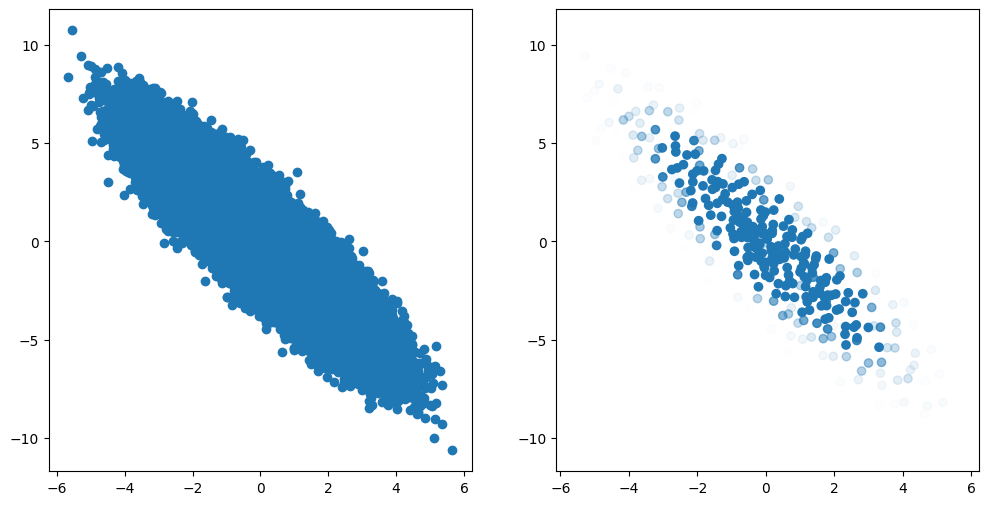

In [6]:
import matplotlib.pyplot as plt

def plot():
    figsize = 6
    fig, axes = plt.subplots(1, 2, figsize=(figsize*2,figsize))
    axes[0].scatter(p[:, 0], p[:, 1])
    axes[1].scatter(p[supp, 0], p[supp, 1], alpha=np.maximum(0., np.minimum(1., w[supp] * len(supp))))
plot()

In [7]:
mmd_P = compute_mmd(kernel, points.subset(supp), w1=w[supp], mode='mean-zero')
print(f'MMD to P: {mmd_P}')

MMD to P: 1.361225487157491e-08
